In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]

In [56]:
class GN_model:
    def __init__(self, span_len, lam_op, num_lam, nl_cof, disp_cof,  alpha, r_sym, bchrs, grid_sp, n_fig, num_spans):
        self.span_len = span_len
        self.lam_op = lam_op
        self.num_lam = num_lam
        self.nl_cof = nl_cof
        self.disp_cof = disp_cof
        self.alpha = alpha
        self.r_sym = r_sym
        self.bchrs = bchrs
        self.grid_sp = grid_sp
        self.n_fig = n_fig
        self.num_spans = num_spans
        self.freq = 299792458/(self.lam_op*1e-9)
        self.al_lin = np.log((10**(self.alpha/10)))/2 # fibre loss [1/km] 
        self.beta2 = (self.disp_cof*(self.lam_op**2))/(2*np.pi*299792.458) # dispersion coefficient at given wavelength [ps^2/km]
        self.l_eff = (1 - np.exp(-2*self.al_lin*self.span_len ))/(2*self.al_lin) # effective length [km]
        self.l_eff_as = 1/(2*self.al_lin) # the asymptotic effective length [km]  
        self.h = 6.63*1e-34 # Planck's constant [Js]
        self.Bwdm = self.bchrs * self.num_lam ** ( self.bchrs / self.grid_sp )  # channel BW [GHz]
        self.epsilon = 0.3*np.log(1 + ( 6 * self.l_eff_as ) / ( self.span_len * np.arcsinh( 0.5*np.pi**2 * self.beta2 *self.l_eff_as * self.Bwdm**2 )  )  )
    def predict_snr(self, p_ch):
        Gwdm = (1e-3*self.convert_to_lin(p_ch))/(self.bchrs*1e9)  # [W]
        Gnli = (1e24*(8/27)*(self.nl_cof**2)*(Gwdm**3)*(self.l_eff**2) ) /(np.pi*self.beta2*self.l_eff_as)  *  (np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )*self.num_spans**(1 + self.epsilon)                                                                             
        Pase = self.n_fig*self.h*self.freq*(self.convert_to_lin(self.alpha*self.span_len) - 1)*self.bchrs*1e9*self.num_spans       
        Pch = 1e-3*10**(p_ch/10) 
        snr = (Pch/(Pase + Gnli*self.bchrs*1e9))
        #snr = ( snr**(-1) + (convert_to_lin(TRxb2b))**(-1) )**(-1)
        return self.convert_to_db(snr)
    
    def find_pch_opt(self):  # return optimal Pch in dBm
        PchdBm = np.linspace(-6,6,500)  # 500 datapoints for higher resolution of Pch
        numpch = len(PchdBm)
        Pchsw = 1e-3*10**(PchdBm/10)  # convert from dBm to linear units [W]
        Gwdmsw = Pchsw/(self.bchrs*1e9)
        Gnlisw = (1e24*(8/27)*(self.nl_cof**2)*(Gwdmsw**3)*(self.l_eff**2) ) /(np.pi*self.beta2*self.l_eff_as)  *  (np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )                                                                            
        G = self.alpha*self.span_len
        NFl = 10**(self.n_fig/10) # convert to linear noise figure
        Gl = 10**(G/10) # convert to linear gain
        Pasesw = NFl*self.h*self.freq*(Gl - 1)*self.bchrs*1e9 # [W] the ASE noise power in one Nyquist channel across all spans
        snrsw = (Pchsw)/(Pasesw*np.ones(numpch) + Gnlisw*self.bchrs*1e9)
        return PchdBm[np.argmax(snrsw)] 
    
    def convert_to_lin(self, x):
        return 10**(x/10)
    
    def convert_to_db(self, x):
        return 10*np.log10(x)

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans 

In [57]:
phys_model = GN_model(100, 1550, 1, 1.27, 16.7, 0.2, 32, 41.6, 50, 4.5, 10)

In [58]:
phys_model.predict_snr(1.0)

13.744474900148019

In [59]:
phys_model.find_pch_opt()

-0.9018036072144291

In [60]:
phys_model.epsilon

0.023652609347601182

In [61]:
snr_gn = phys_model.predict_snr(pch)

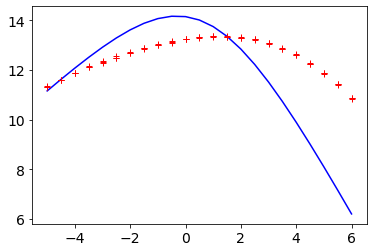

In [62]:
plt.plot(pch, snr_gn, 'b-')
plt.plot(pch, snr, 'r+')
plt.show()

Still appears to be miles off - could be a case of getting the correct input parameters but the shapes look so different...
Another idea: use the simple model for system performance David uses in his (as yet not accepted) paper:
$SNR^{-1} = {SNR_0}^{-1}\frac{1}{N} \sum_{i=1}^N \frac{2 + p_i^3}{3p_i} + \sigma g $.
* N = number of spans
* $SNR_0$ = estimate of peak SNR 
* p = power divided by the optimal power, such that at $p=p_0$, $SNR = SNR_0$
* g = _N_(0,1)
Note that in this case, the launch powers are uniform so we can replace the sum with multiplying by the number of spans.

In [63]:
max(snr)

13.365315517943994

In [64]:
np.random.normal(0, 1)

-0.6383000777599432

In [65]:
class simple_snr_model:
    def __init__(self, num_spans, snr_pk, p_opt, sigma):
        self.num_spans = num_spans
        self.snr_pk = self.convert_to_lin(snr_pk)
        self.p_opt = 1e-3*self.convert_to_lin(p_opt)
        self.sigma = sigma
        print(self.snr_pk)
    
#     def predict_snr(self, p_in):
#         p_in = 1e-3*self.convert_to_lin(p_in)
#         p_norm = p_in/self.p_opt
#         snr = 1 / ( self.snr_pk**(-1) * self.num_spans * ( (2 + p_norm**3) / (3 * p_norm )  ) )
#         return self.convert_to_db(snr)  + self.sigma*np.random.normal(0, 1) 

    def predict_snr(self, p_in):
        p_in = 1e-3*self.convert_to_lin(p_in)
        print(p_in)
        p_norm = p_in/self.p_opt
        return  self.convert_to_db((3*p_norm /(2 + p_norm**3))*self.snr_pk)  + self.sigma*np.random.normal(0, 1) 
        
    def convert_to_lin(self, x):
        return 10**(x/10)
    
    def convert_to_db(self, x):
        return 10*np.log10(x)
    

In [66]:
ten_span_model = simple_snr_model(10, 13.3, 1.5, 0.045)

21.379620895022324


In [67]:
snr_simple = ten_span_model.predict_snr(pch)

[0.00031623 0.00031623 0.00031623 0.00035481 0.00035481 0.00035481
 0.00039811 0.00039811 0.00039811 0.00044668 0.00044668 0.00044668
 0.00050119 0.00050119 0.00050119 0.00056234 0.00056234 0.00056234
 0.00063096 0.00063096 0.00063096 0.00070795 0.00070795 0.00070795
 0.00079433 0.00079433 0.00079433 0.00089125 0.00089125 0.00089125
 0.001      0.001      0.001      0.00112202 0.00112202 0.00112202
 0.00125893 0.00125893 0.00125893 0.00141254 0.00141254 0.00141254
 0.00158489 0.00158489 0.00158489 0.00177828 0.00177828 0.00177828
 0.00199526 0.00199526 0.00199526 0.00223872 0.00223872 0.00223872
 0.00251189 0.00251189 0.00251189 0.00281838 0.00281838 0.00281838
 0.00316228 0.00316228 0.00316228 0.00354813 0.00354813 0.00354813
 0.00398107 0.00398107 0.00398107]


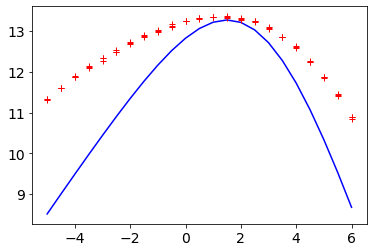

In [68]:
plt.plot(pch, snr_simple, 'b-')
plt.plot(pch, snr, 'r+')
plt.show()